<a href="https://colab.research.google.com/github/Geringer13/Netology_pyda/blob/master/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9D%D0%B5%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Дипломная работа Герингер Владимир Владимирович - Анализ корреляции различных промоционных каналов на продажи из аптек в фармацевтической отрасли.**




In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Прочитаем файл и посмотрим основыне показатели**

In [268]:
data = pd.read_csv('Baikal_Progressa_tmp_big_202008190939 (1).csv')
data.head()

,date_c,corporation,brand,Promotion,speciality,Speciality_Promotion,sell_in_packs,sell_in_rub,sell_out_packs,sell_out_rub,promo_amount,prescr_amount
0,2016-01-01 00:00:00,APTEKA-A.V.E.,ГИНКГО БИЛОБА,POS-материалы,Фармацевты,Фармацевты \ POS-материалы,0.0,0.0,0.0,0.0,1.0,0
1,2016-01-01 00:00:00,APTEKA-A.V.E.,ГИНКГО БИЛОБА,Визиты МП,Фармацевты,Фармацевты \ Визиты МП,0.0,0.0,0.0,0.0,1.0,0
2,2016-01-01 00:00:00,APTEKA-A.V.E.,ЛОРАТАДИН,POS-материалы,Фармацевты,Фармацевты \ POS-материалы,0.0,0.0,0.0,0.0,3.0,0
3,2016-01-01 00:00:00,APTEKA-A.V.E.,ЛОРАТАДИН,Визиты МП,Фармацевты,Фармацевты \ Визиты МП,0.0,0.0,0.0,0.0,4.0,0
4,2016-01-01 00:00:00,APTEKA-A.V.E.,ЛОРАТАДИН,ТВ-реклама/Видеоряд,Фармацевты,Фармацевты \ ТВ-реклама/Видеоряд,0.0,0.0,0.0,0.0,6.0,0


**Описание данных**

date_c	- дата

corporation	- фармкомпания

brand	- препарат

Promotion	- тип промоций

speciality - специальность целевой аудитории

Speciality_Promotion - тип промоций к определённой специальности (speciality+Promotion)

sell_in_packs	- закупки в упаковках

sell_in_rub	- закупки в рублях

sell_out_packs - продажи в упаковках

sell_out_rub - продажи в рублях (ТАРГЕТ)

promo_amount - кол-во промоционных активностей суммарно по препарату

prescr_amount - кол-во врачебных назначений суммарно по препарату


In [9]:
len(data)

971938

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971938 entries, 0 to 971937
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   date_c                971938 non-null  object 
 1   corporation           971938 non-null  object 
 2   brand                 971938 non-null  object 
 3   Promotion             182006 non-null  object 
 4   speciality            291245 non-null  object 
 5   Speciality_Promotion  971938 non-null  object 
 6   sell_in_packs         964746 non-null  float64
 7   sell_in_rub           964746 non-null  float64
 8   sell_out_packs        971694 non-null  float64
 9   sell_out_rub          971694 non-null  float64
 10  promo_amount          971938 non-null  float64
 11  prescr_amount         971938 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 89.0+ MB


**Как мы видим много нулевых значений в полях промоционные активности и специальности целевой аудитории - это означает, что большинство препаратов, которые продаются в аптеках не имеют промоционной активности со стороны производителей. Эти пустые значения мы так и оставляем, потому что нам интересно понимать, оказывают ли влияние промо активности на продажи или нет, и, если их нет, но продажи меняются мы должны это учитывать.**

In [11]:
data.isnull().sum()

date_c                       0
corporation                  0
brand                        0
Promotion               789932
speciality              680693
Speciality_Promotion         0
sell_in_packs             7192
sell_in_rub               7192
sell_out_packs             244
sell_out_rub               244
promo_amount                 0
prescr_amount                0
dtype: int64

In [34]:
data.describe()

,sell_in_packs,sell_in_rub,sell_out_packs,sell_out_rub,promo_amount,prescr_amount
count,9.647460e+05,9.647460e+05,9.716940e+05,9.716940e+05,971938.000000,9.719380e+05
mean,3.871655e+04,6.011855e+06,3.754311e+04,7.158463e+06,136.193632,1.750864e+03
std,2.321701e+05,3.816622e+07,2.279990e+05,4.489573e+07,681.565195,1.967838e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,5.410519e+01,4.076000e+03,6.700000e+01,7.455982e+03,0.000000,0.000000e+00
75%,3.781991e+03,3.915476e+05,3.758261e+03,5.312215e+05,0.000000,0.000000e+00
max,1.358090e+07,2.418381e+09,1.384246e+07,2.527245e+09,68821.000000,1.896912e+06


**Давайте изучим данные. Для построим топы, переведём категориальные признаки в цифры и выполним нормирование данных.**

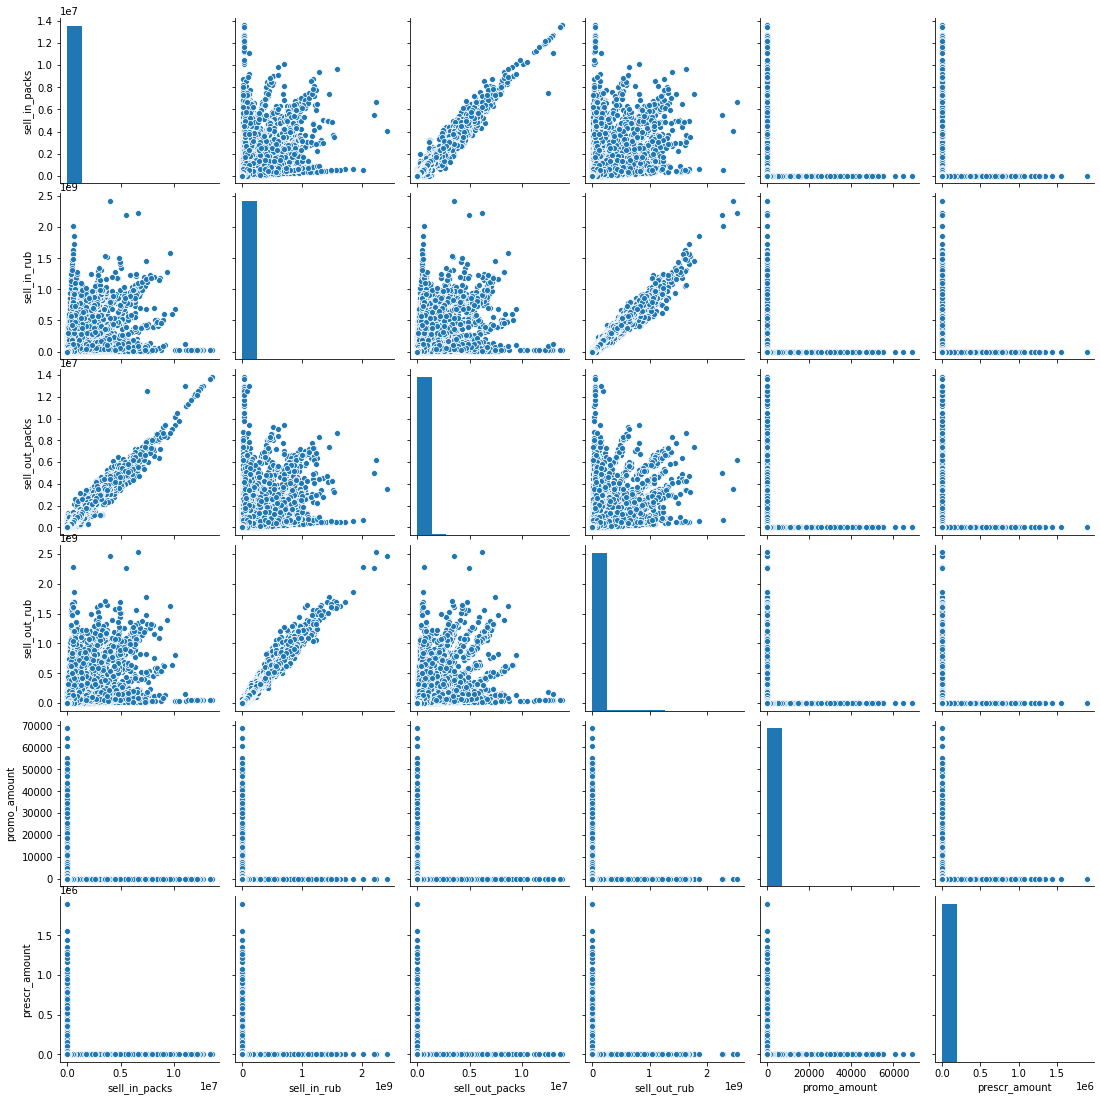

In [63]:
sns.pairplot(data)

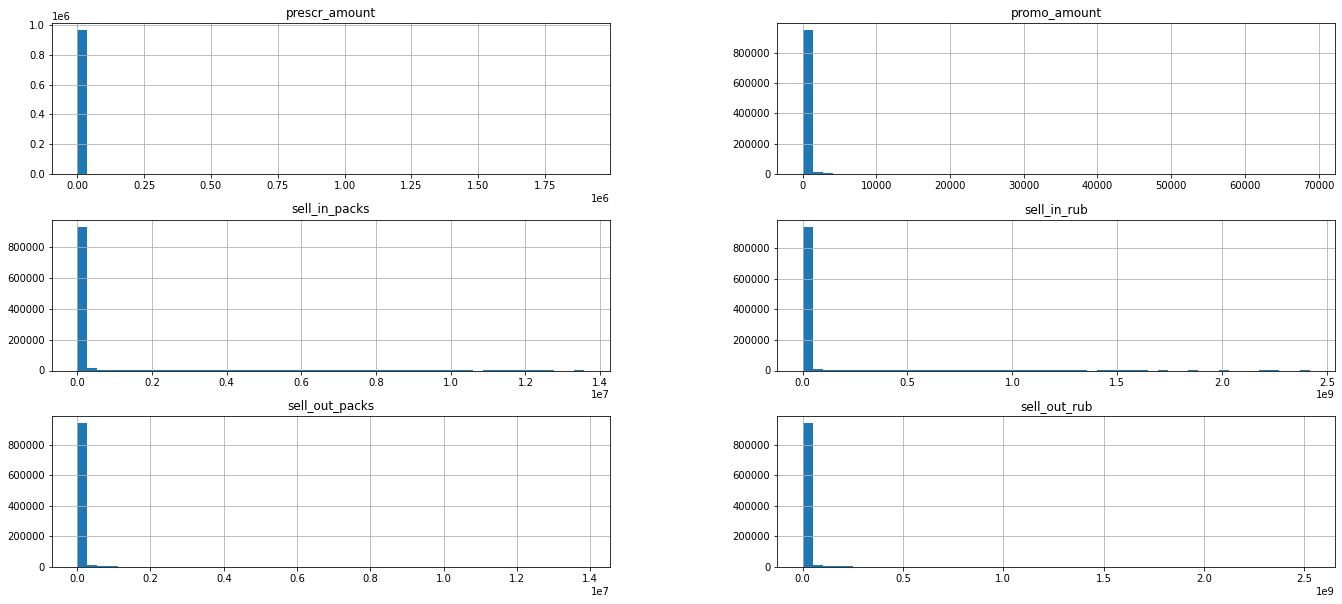

In [64]:
data.hist(figsize=(23,10), bins=50)
plt.show()

In [66]:
# Построим рейтинг ТОП-10 компаний по продажам из аптек
sales = data.groupby('corporation').sum().sort_values('sell_out_rub', ascending=True).reset_index()

In [75]:
sales = sales.sort_values(by='sell_out_rub').head(10)

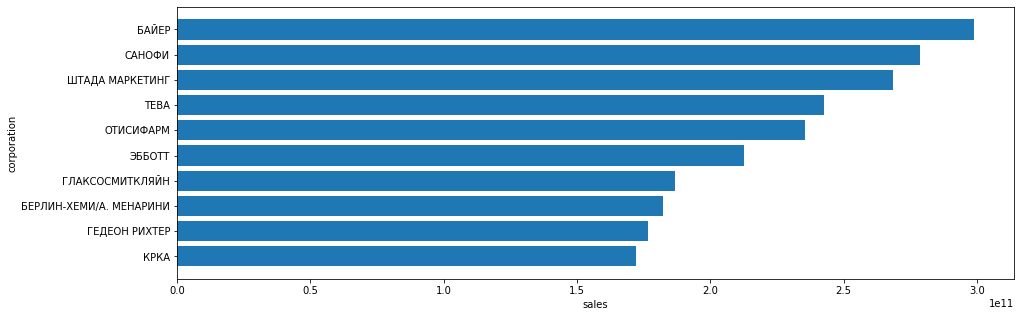

In [76]:
plt.figure(figsize=(15,5))
plt.barh(sales['corporation'], sales['sell_out_rub'])
plt.xlabel('sales')
plt.ylabel('corporation')
plt.show()

In [115]:
# Построим рейтинг ТОП-10 компаний по промоционной активности, самые активные компании на рынке по продвижению своих препаратов.
promo = data.groupby('corporation').sum().sort_values('promo_amount', ascending=False).reset_index()

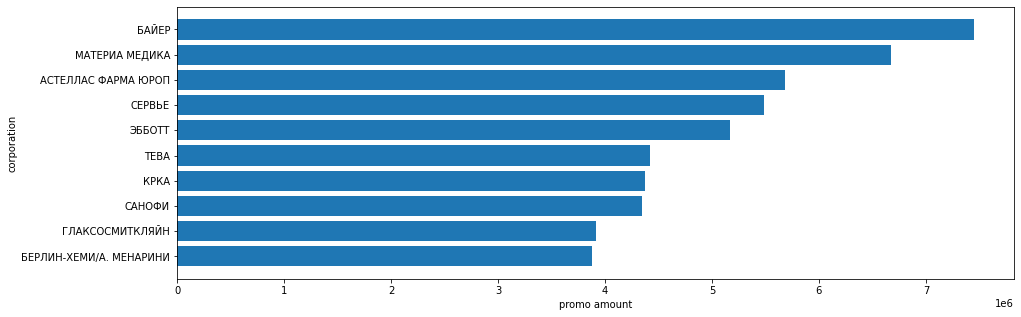

In [124]:
plt.figure(figsize=(15,5))
plt.barh(promo['corporation'], promo['promo_amount'].sort_values(ascending=True))
plt.xlabel('promo amount')
plt.ylabel('corporation')
plt.show()

In [128]:
# Теперь построим рейтинг ТОП-10 компаний по назначениям, самые назначаемые врачами компании на рынке. Мы видим, что чаще всего "Любая компания", 
# врачи не указывают производителя.
prescription = data.groupby('corporation').sum().sort_values('prescr_amount', ascending=False).reset_index()

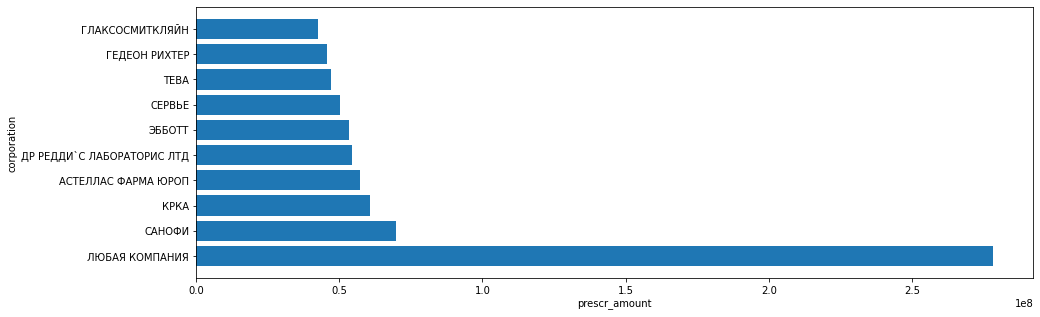

In [145]:
plt.figure(figsize=(15,5))
plt.barh(prescription['corporation'], prescription['prescr_amount'])
plt.ylabel('corporation')
plt.xlabel('prescr_amount')
plt.show()

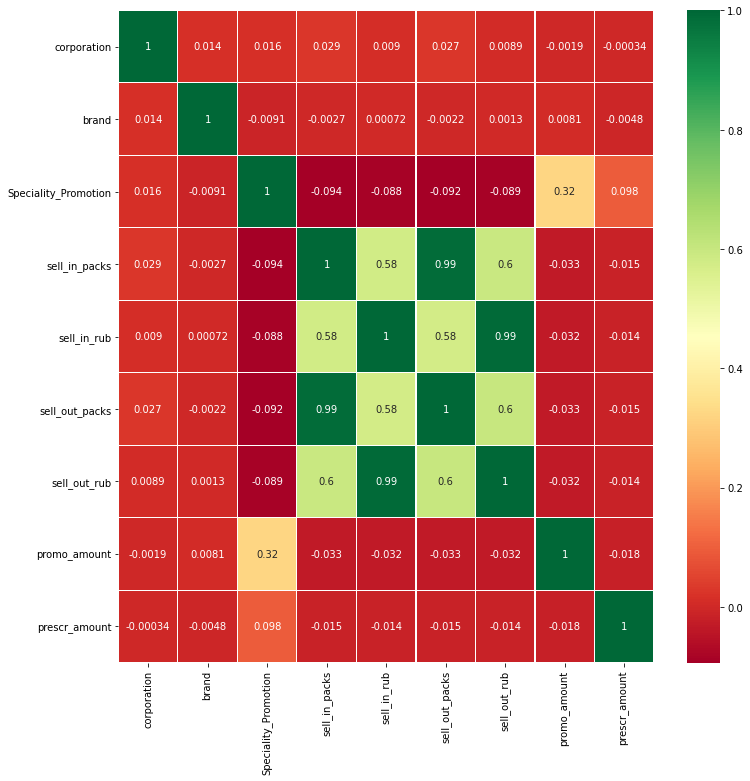

In [159]:
# Мы видим, что нет корреляции между промо и продажами, попробуем изменить формат данных
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

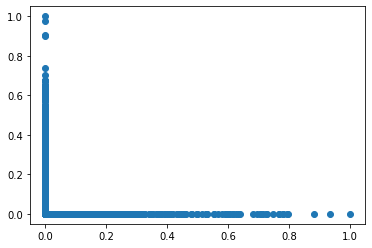

In [169]:
# Здесь мы пытаемся понять, влияет ли кол-во промоционных усилий на продажи, и видим, что нет, но мы помним, что мы смотрим через призму всего датасета
# отфильтруем нулевые значения по столбцу промоции.

plt.scatter(df_norm['promo_amount'], df_norm['sell_out_rub'])

**Трансформируем наши данные по дате, компании и препарату. И переведём столбец Speciality_Promotion в число.**

In [294]:
le = LabelEncoder()

In [295]:
data['Speciality_Promotion'] = le.fit_transform(data['Speciality_Promotion'])

In [297]:
data_g = data.groupby(['date_c', 'corporation', 'brand']).sum()

In [299]:
len(data_g)

711517

In [300]:
# Теперь ограничим наш датасет только теми препаратами, которые имели промоционное продвижение, тоесть их значение более 20.
data_g = data_g[data_g['promo_amount'] > 20]

In [301]:
len(data_g)

34217

In [302]:
data_g.describe()

,Speciality_Promotion,sell_in_packs,sell_in_rub,sell_out_packs,sell_out_rub,promo_amount,prescr_amount
count,34217.000000,3.421700e+04,3.421700e+04,3.421700e+04,3.421700e+04,34217.000000,3.421700e+04
mean,293.271327,2.019364e+05,4.491854e+07,2.013415e+05,5.362065e+07,3867.326145,3.995905e+04
std,285.895098,5.512456e+05,1.032339e+08,5.557271e+05,1.232812e+08,8658.060601,1.234836e+05
min,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.010000,0.000000e+00
25%,85.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,178.000000,0.000000e+00
50%,194.000000,1.898558e+04,6.331169e+06,1.857717e+04,7.724409e+06,647.000000,5.200000e+02
75%,397.000000,1.398929e+05,3.700179e+07,1.352939e+05,4.433781e+07,3207.000000,2.095200e+04
max,1811.000000,9.189712e+06,1.638893e+09,9.399751e+06,1.694640e+09,185371.000000,2.133938e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6dc60314a8>,
      dtype=object)

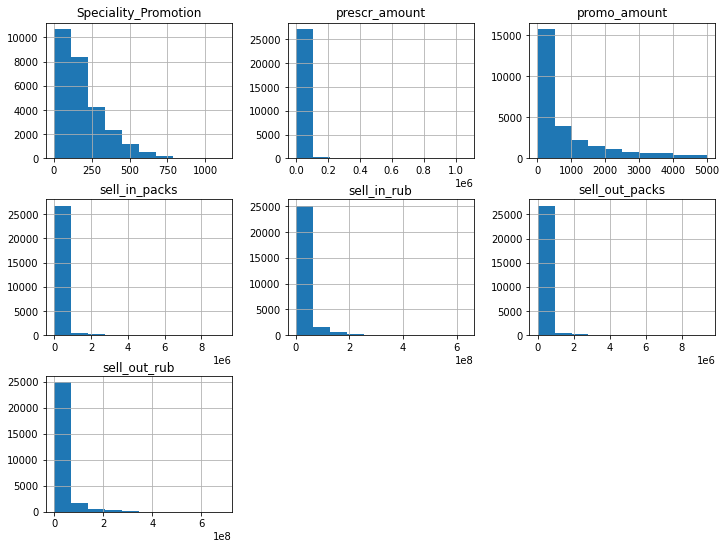

In [305]:
data_g[data_g['promo_amount'] < 5000].hist()

**Теперь оценим влияние промоционных активностей и назначений на продажи**

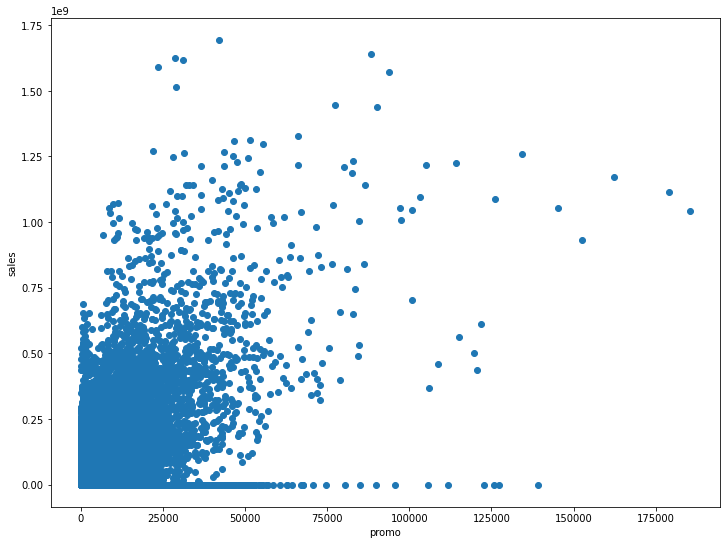

In [310]:
# На трёх графиках видна не явная зависимость переменных.
plt.scatter(data_g['promo_amount'], data_g['sell_out_rub'])
plt.xlabel('promo')
plt.ylabel('sales')
plt.show()

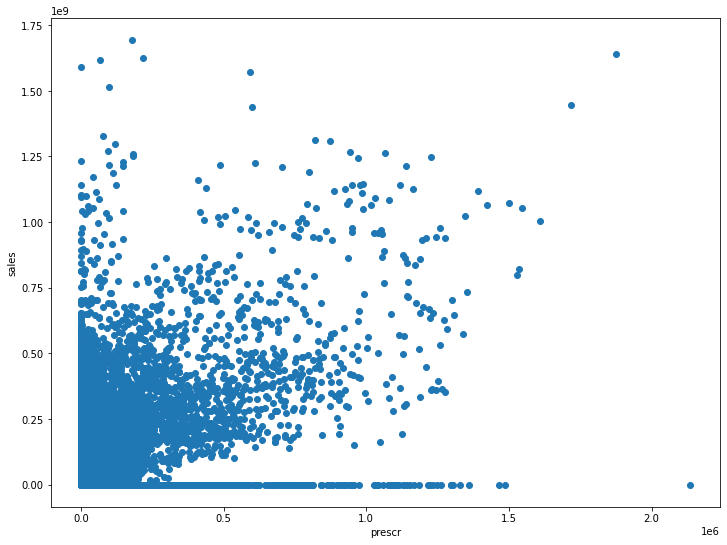

In [311]:
plt.scatter( data_g['prescr_amount'], data_g['sell_out_rub'])
plt.xlabel('prescr')
plt.ylabel('sales')
plt.show()

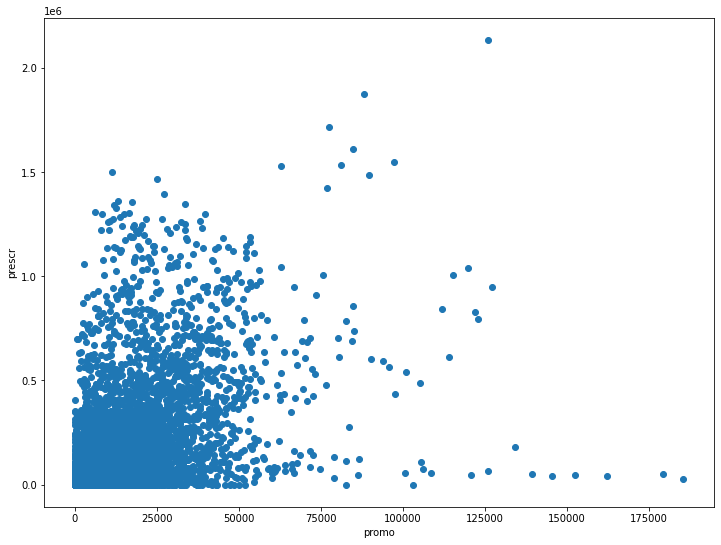

In [312]:
plt.scatter(data_g['promo_amount'], data_g['prescr_amount'])
plt.xlabel('promo')
plt.ylabel('prescr')
plt.show()

In [321]:
# Оставим в датасете только необходимые столбцы, так как тема дипломной работы - влияние промо и назначений на продажи из аптек, а не на закупку.
data_g = data_g[['prescr_amount', 'promo_amount', 'sell_out_rub', 'Speciality_Promotion']]

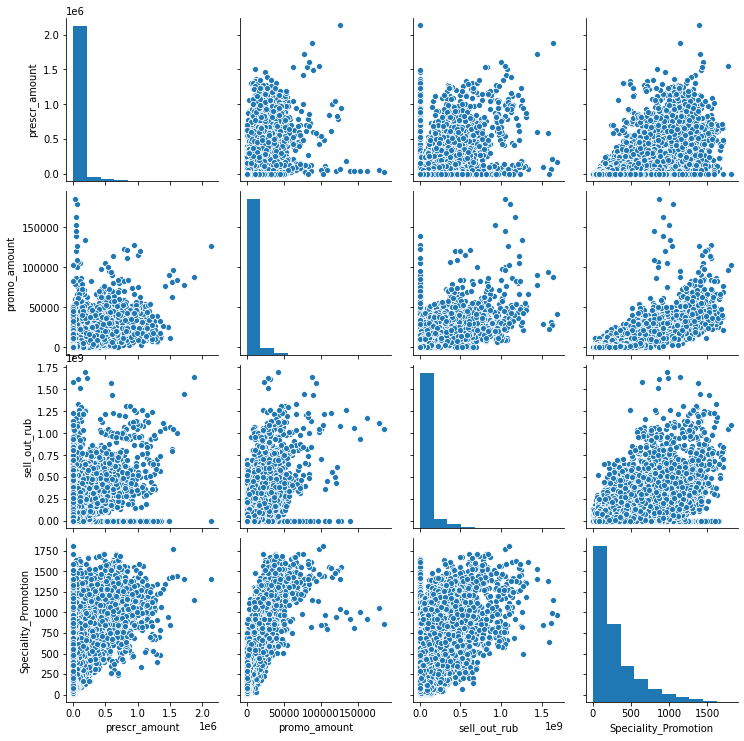

In [325]:
sns.pairplot(data_g)

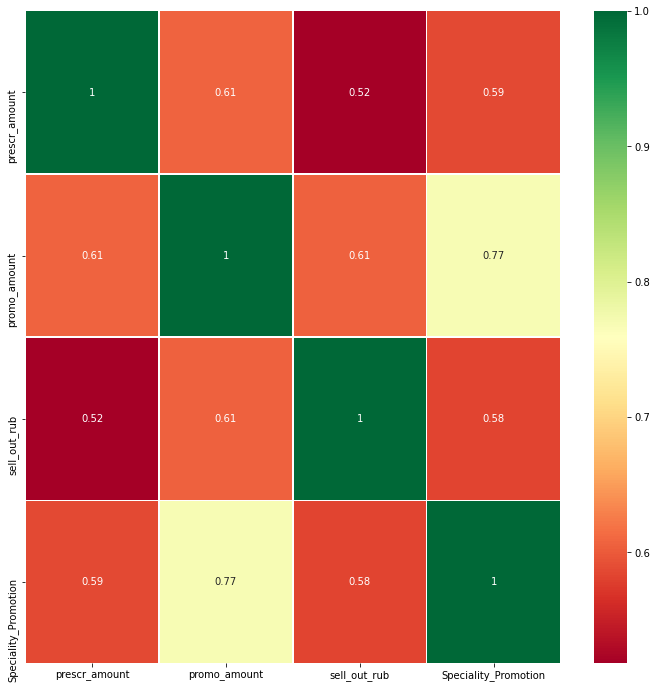

In [323]:
# Теперь уже лучше! Мы видим, что на отфильтрованном датасете, влияние промоционных активностей и назначений на продажи выше среднего.
sns.heatmap(data_g.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [331]:
headers = list(data_g.columns.values)

In [332]:
headers

['prescr_amount', 'promo_amount', 'sell_out_rub', 'Speciality_Promotion']

In [334]:
# Попробуем нормализовать и посмотреть снова, видим, что ничего не изменилось.
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np_scaled = min_max_scaler.fit_transform(data_g)
df_norm = pd.DataFrame(np_scaled)
df_norm.columns = headers
df_norm.head()

,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion
0,0.0,0.000059,0.0,0.074074
1,0.0,0.001451,0.0,0.065229
2,0.0,0.012085,0.0,0.039248
3,0.0,0.000032,0.0,0.124378
4,0.0,0.001020,0.0,0.009950


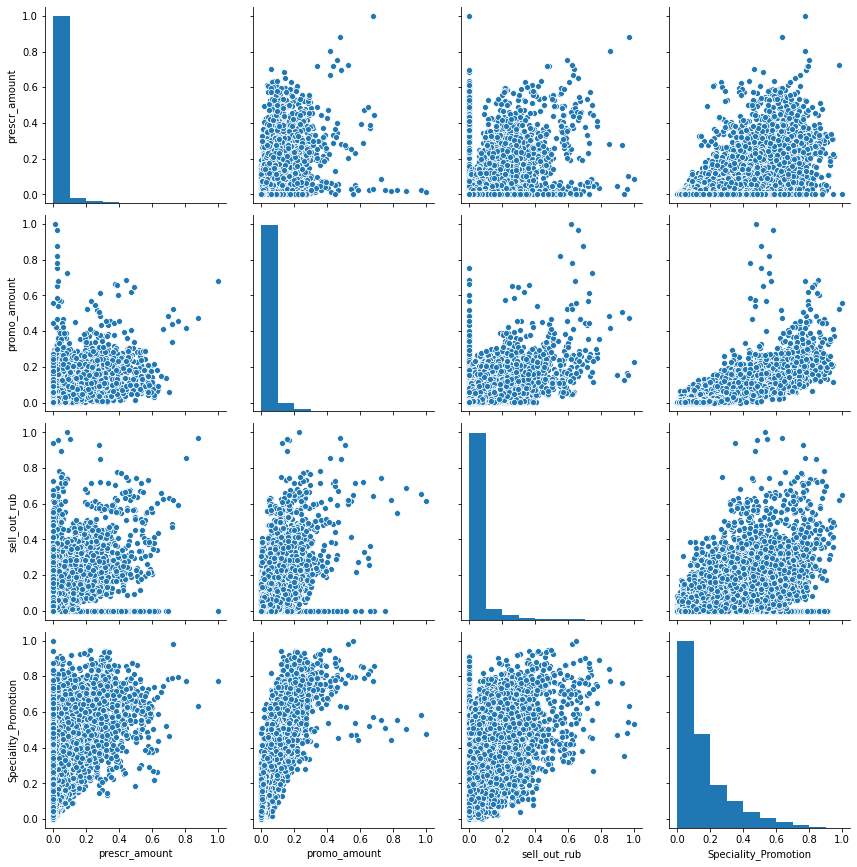

In [335]:
sns.pairplot(df_norm) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

**Итак, у нас есть отфильтрованный, нормализованный датасет, на котором мы будем обучать модели и сравнивать результаты. Мы попытаемся понять какие из Specialty_promotions оказывают бОльшее влияние на продажи, а также попробуем предсказать продажи отталкиваясь от остальных показателей.**

In [348]:
data_g.head()

prescr_amount  ...  Speciality_Promotion
date_c              corporation brand                      ...                      
2016-01-01 00:00:00 BAZIS       АНАЛЬГИН                0  ...                   136
                                ДИМЕКСИД                0  ...                   120
                                ДИМЕФОСФОН              0  ...                    73
                                ИБУПРОФЕН               0  ...                   227
                                КОФЕТАМИН               0  ...                    20

[5 rows x 4 columns]

In [350]:
X = data_g.drop('sell_out_rub', axis=1)
y = data_g.sell_out_rub

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Линейная регрессия.**

In [352]:
# Обучим линейную регрессию
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
prediction_lin = model_lin.predict(X_test)

In [353]:
model_lin.score(X_test, y_test)

0.44043247487470205

In [354]:
print("MAE: \t", mean_absolute_error(y_test, prediction_lin))

MAE: 	 46085235.62691544


In [356]:
# for i, j in zip(y_test, prediction_lin):
#     print('target:', i, 'pred:', j)

**Полиномиальная регрессия.**

In [362]:
# давайте попробуем полиномиальную регрессию
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
# prediction_poly = model_lin.predict(X_poly)
pol_reg.score(poly_reg.fit_transform(X_test), y_test)

0.44716285825986146

In [367]:
# print("MAE: \t", mean_absolute_error(y_test, X_poly))

**Деревья решений. Присвоим диапазонам продаж 3 категории, и будем предсказывать эти диапазоны.
1 категория - продажи от 1 млрд. рублей и выше
2 категория - продажи от 500 млн. рублей до 1 млрд. рублей
3 категория - продажи от 1 рубля до 500 млн. рублей**

In [369]:
data_proba = data_g[data_g['sell_out_rub'] > 1] 
data_proba.head()

prescr_amount  ...  Speciality_Promotion
date_c              corporation brand                         ...                      
2017-01-01 00:00:00 АВВА РУС    АМОКСИЦИЛЛИН             358  ...                   207
                                ДИНОЛАК                 3524  ...                   177
                                КЛАРИТРОМИЦИН              0  ...                    26
                                ЛЕВОФЛОКСАЦИН              0  ...                    26
                                МИКРАЗИМ               99414  ...                   622

[5 rows x 4 columns]

In [372]:
data_proba = data_proba.sort_values(by='sell_out_rub',ascending=False).reset_index()

In [373]:
data_proba.head()

,index,date_c,corporation,brand,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion
0,24394,2019-10-01 00:00:00,БАЙЕР,КСАРЕЛТО,177537,42012.00,1.694640e+09,969
1,24393,2017-01-01 00:00:00,ВАЛЕНТА ФАРМ,ИНГАВИРИН,1876052,88246.00,1.639449e+09,1151
2,24392,2020-01-01 00:00:00,БАЙЕР,КСАРЕЛТО,217314,28561.40,1.627068e+09,989
3,24391,2019-07-01 00:00:00,БАЙЕР,КСАРЕЛТО,67225,31206.00,1.617631e+09,873
4,24390,2020-04-01 00:00:00,БАЙЕР,КСАРЕЛТО,0,23391.72,1.589095e+09,640


In [374]:
data_proba = data_proba.drop('index', axis=1)

In [375]:
data_proba.head()

,date_c,corporation,brand,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion
0,2019-10-01 00:00:00,БАЙЕР,КСАРЕЛТО,177537,42012.00,1.694640e+09,969
1,2017-01-01 00:00:00,ВАЛЕНТА ФАРМ,ИНГАВИРИН,1876052,88246.00,1.639449e+09,1151
2,2020-01-01 00:00:00,БАЙЕР,КСАРЕЛТО,217314,28561.40,1.627068e+09,989
3,2019-07-01 00:00:00,БАЙЕР,КСАРЕЛТО,67225,31206.00,1.617631e+09,873
4,2020-04-01 00:00:00,БАЙЕР,КСАРЕЛТО,0,23391.72,1.589095e+09,640


In [376]:
data_proba = data_proba.applymap(lambda x: int(x) if isinstance(x, float) else x)

In [400]:
data_proba.loc[:78, 'level_0'] = '1'
data_proba.loc[79:547, 'level_0'] = '2'
data_proba.loc[548:, 'level_0'] = '3'

In [401]:
data_proba

,date_c,corporation,brand,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion,level_0
0,2019-10-01 00:00:00,БАЙЕР,КСАРЕЛТО,177537,42012,1694640184,969,1
1,2017-01-01 00:00:00,ВАЛЕНТА ФАРМ,ИНГАВИРИН,1876052,88246,1639449123,1151,1
2,2020-01-01 00:00:00,БАЙЕР,КСАРЕЛТО,217314,28561,1627067962,989,1
3,2019-07-01 00:00:00,БАЙЕР,КСАРЕЛТО,67225,31206,1617631414,873,1
4,2020-04-01 00:00:00,БАЙЕР,КСАРЕЛТО,0,23391,1589094897,640,1
...,...,...,...,...,...,...,...,...
24390,2017-07-01 00:00:00,РОЗФАРМ,АМБРОКСОЛ,0,347,69,43,3
24391,2020-01-01 00:00:00,ВАЛЕНТА ФАРМ,ПЕНТОВИТ,0,417,61,221,3
24392,2019-04-01 00:00:00,БРИСТОЛ-МАЙЕРС СКВИББ,МАКСИПИМ,0,790,49,74,3
24393,2018-01-01 00:00:00,ФАРМАСИНТЕЗ,БРОМГЕКСИН,0,1971,47,275,3


In [416]:
X_1 = data_proba.drop(['level_0', 'sell_out_rub', 'date_c', 'corporation', 'brand'], axis=1)
y_1 = data_proba['level_0']

In [417]:
X_1train, X_1test, y_1train, y_1test = train_test_split(X_1, y_1, test_size=0.3)

In [418]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.5)

In [419]:
dt.fit(X_1train, y_1train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

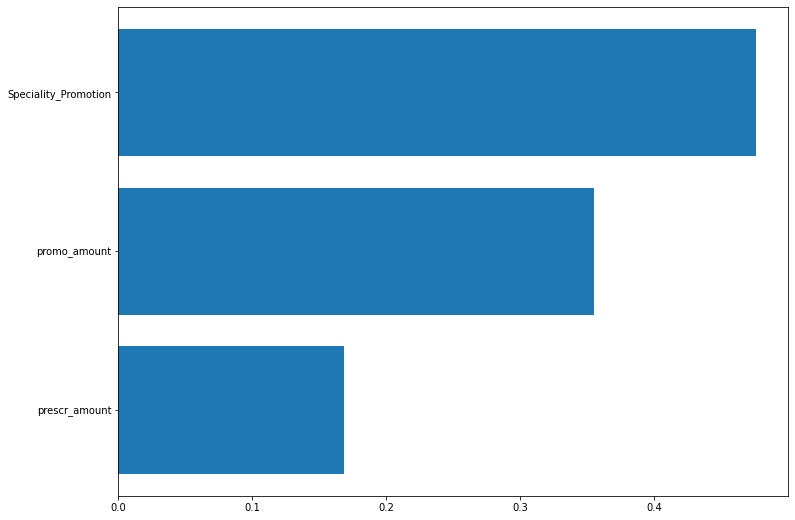

In [422]:
# наиболее важные фичи
plt.barh(np.arange(len(dt.feature_importances_)), dt.feature_importances_)
plt.yticks(np.arange(len(X_1.columns)),X_1.columns)
plt.show()

In [423]:
dt.score(X_1test, y_1test)

0.9766361524798469

**Отличный результат! Но, мы делали всего 3 даипазона, наверно это слишком просто, теперь увеличим кол-во диапазонов до 6. 6 категория - продажи от  1 рубля до 100 млн рублей, 5 категория - продажи от  100 млн. рублей до 200 млн, 4 категория - продажи от  200 млн. рублей до 400 млн, 3 категория - продажи от 400 млн. рублей до 700 млн. рублей, 2 категория - продажи от 700 млн. рублей до 1 млрд. рублей, 1 категория - продажи от 1 млрд. рублей и выше**

In [433]:
data_proba_new = data_g[data_g['sell_out_rub'] > 1] 
data_proba.head()

,date_c,corporation,brand,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion,level_0
0,2019-10-01 00:00:00,БАЙЕР,КСАРЕЛТО,177537,42012,1694640184,969,1
1,2017-01-01 00:00:00,ВАЛЕНТА ФАРМ,ИНГАВИРИН,1876052,88246,1639449123,1151,1
2,2020-01-01 00:00:00,БАЙЕР,КСАРЕЛТО,217314,28561,1627067962,989,1
3,2019-07-01 00:00:00,БАЙЕР,КСАРЕЛТО,67225,31206,1617631414,873,1
4,2020-04-01 00:00:00,БАЙЕР,КСАРЕЛТО,0,23391,1589094897,640,1


In [434]:
data_proba_new = data_proba_new.sort_values(by='sell_out_rub',ascending=False).reset_index()

In [483]:
data_proba_new.loc[:78, 'level_0'] = '1'
data_proba_new.loc[79:225, 'level_0'] = '2'
data_proba_new.loc[226:992, 'level_0'] = '3'
data_proba_new.loc[993:2600, 'level_0'] = '4'
data_proba_new.loc[2601:4930, 'level_0'] = '5'
data_proba_new.loc[4931:, 'level_0'] = '6'

In [485]:
data_proba_new

,date_c,corporation,brand,prescr_amount,promo_amount,sell_out_rub,Speciality_Promotion,level_0
0,2019-10-01 00:00:00,БАЙЕР,КСАРЕЛТО,177537,42012.00,1.694640e+09,969,1
1,2017-01-01 00:00:00,ВАЛЕНТА ФАРМ,ИНГАВИРИН,1876052,88246.00,1.639449e+09,1151,1
2,2020-01-01 00:00:00,БАЙЕР,КСАРЕЛТО,217314,28561.40,1.627068e+09,989,1
3,2019-07-01 00:00:00,БАЙЕР,КСАРЕЛТО,67225,31206.00,1.617631e+09,873,1
4,2020-04-01 00:00:00,БАЙЕР,КСАРЕЛТО,0,23391.72,1.589095e+09,640,1
...,...,...,...,...,...,...,...,...
24390,2017-07-01 00:00:00,РОЗФАРМ,АМБРОКСОЛ,0,347.00,6.900000e+01,43,6
24391,2020-01-01 00:00:00,ВАЛЕНТА ФАРМ,ПЕНТОВИТ,0,417.43,6.112158e+01,221,6
24392,2019-04-01 00:00:00,БРИСТОЛ-МАЙЕРС СКВИББ,МАКСИПИМ,0,790.00,4.900000e+01,74,6
24393,2018-01-01 00:00:00,ФАРМАСИНТЕЗ,БРОМГЕКСИН,0,1971.00,4.779463e+01,275,6


In [486]:
X_2 = data_proba.drop(['level_0', 'sell_out_rub', 'date_c', 'corporation', 'brand'], axis=1)
y_2 = data_proba['level_0']

In [489]:
X_2train, X_2test, y_2train, y_2test = train_test_split(X_2, y_2, test_size=0.3)

In [490]:
dt1 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.5)

In [491]:
dt1.fit(X_2train, y_2train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

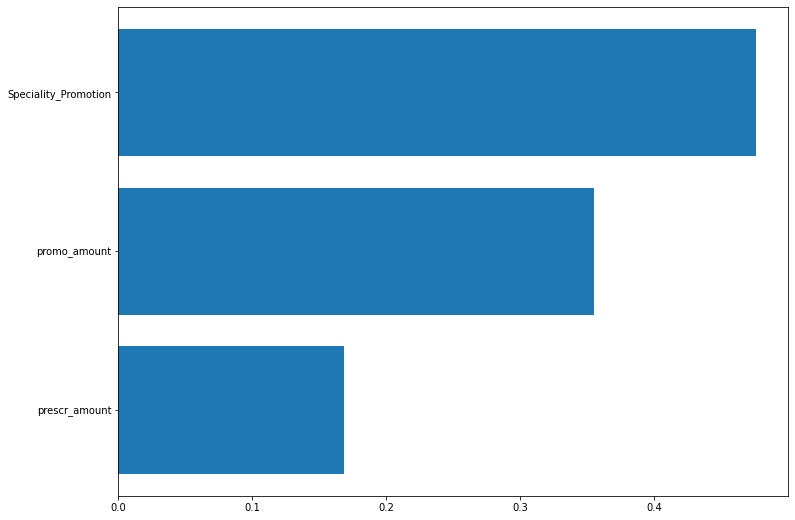

In [492]:
# наиболее важные фичи
plt.barh(np.arange(len(dt1.feature_importances_)), dt.feature_importances_)
plt.yticks(np.arange(len(X_2.columns)),X_2.columns)
plt.show()

In [493]:
dt1.score(X_2test, y_2test)

0.9774559366033612

In [494]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_2train, y_2train)   

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [495]:
clf_rf.score(X_2test, y_2test)

0.9778658286651182

In [496]:
k_range = list(range(1, 10))

In [497]:
param_grid = dict(n_neighbors=k_range)

In [498]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')

In [499]:
grid.fit(X_2, y_2)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [500]:
for k in grid.cv_results_:
    print(k, ":", grid.cv_results_[k][0])

mean_fit_time : 0.049775552749633786
std_fit_time : 0.004543348089163838
mean_score_time : 0.06656951904296875
std_score_time : 0.004134769654226799
param_n_neighbors : 1
params : {'n_neighbors': 1}
split0_test_score : 0.7602459016393442
split1_test_score : 0.9586065573770491
split2_test_score : 0.9770491803278688
split3_test_score : 0.9758196721311475
split4_test_score : 0.9790983606557377
split5_test_score : 0.983189831898319
split6_test_score : 0.980319803198032
split7_test_score : 0.981549815498155
split8_test_score : 0.977449774497745
split9_test_score : 0.9790897908979089
mean_test_score : 0.9552418688121307
std_test_score : 0.06531990456680849
rank_test_score : 7


In [501]:
test_scores = grid.cv_results_['mean_test_score']
print(test_scores)

[0.95524187 0.94114363 0.95954521 0.95520105 0.96192221 0.95811075
 0.96138924 0.95905323 0.9618811 ]


Text(0, 0.5, 'Cross-Validated Accuracy')

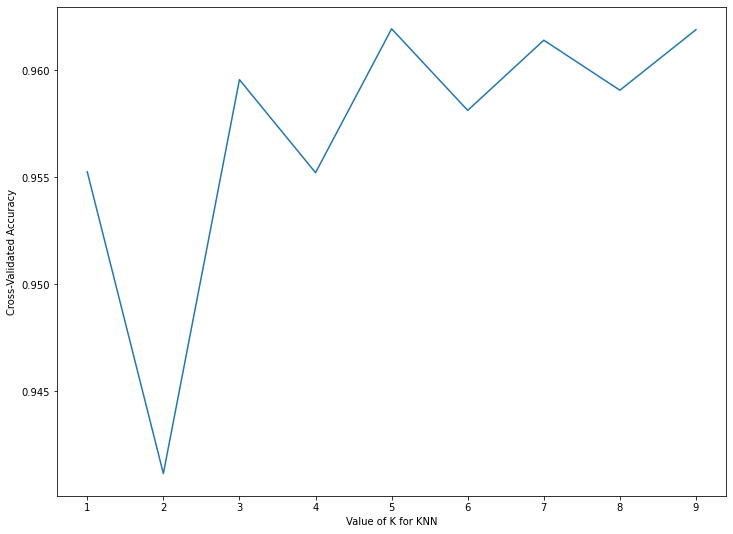

In [502]:
plt.plot(k_range, test_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [503]:
print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

0.96192221348443
{'n_neighbors': 5}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [504]:
predictions = clf_rf.predict(X_2test)

''

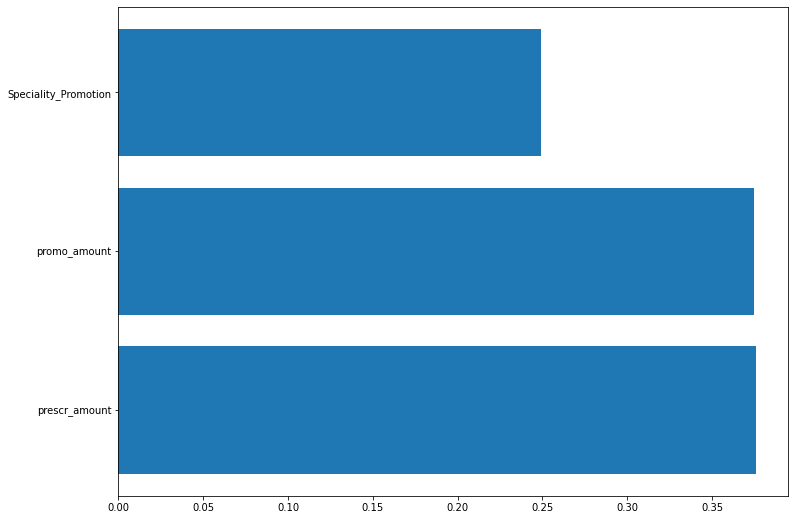

In [505]:
plt.barh(np.arange(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.yticks(np.arange(len(X_2.columns)),X_2.columns)
''

**Конец**